In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import cv2
from perspective_transform import *
from lane_find import *
from color_filtering import *
from calib_camera import *
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

### Step by Step Detection of lane lines

#### 1. Camera Calibration

Calibrate the camera using the images in `camera_cal` directory

In [23]:
nx = 9
ny = 6
images = glob.glob("camera_cal/calibration*.jpg")
pickle_file = "camera_cal/dist_pickle.p"

In [24]:
# Find object and image points and use these to calibrate the camera
objpoints, imgpoints = find_obj_and_img_points(images, nx, ny)
mtx, dist = calibrate_camera(objpoints, imgpoints, (1280, 720))

# save required variables in a pickle file
dict_pickle = dict(objpoints=objpoints, imgpoints=imgpoints, mtx=mtx, dist=dist)
pickle.dump(dict_pickle, open(pickle_file, "wb"))

2019-09-29 12:33:24,931 - CalibCamera - INFO - Found corners on 17 images
2019-09-29 12:33:25,717 - CalibCamera - INFO - Returned mtx and dist from camera calibration


#### 2. Undistort and transform perspective

Let's use one image as an example and transform that into a bird-eye view after undistorting it

In [2]:
def plot_image(img, cv2_colormap=None, cmap=None, figsize=(24,9)):
    if cv2_colormap is not None:
        img = cv2.cvtColor(img, cv2_colormap)
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    
plot_color_image = partial(plot_image, cv2_colormap=cv2.COLOR_BGR2RGB)
plot_gray_image = partial(plot_image, cv2_colormap=cv2.COLOR_BGR2GRAY)
plot_bw_image = partial(plot_image, cmap="gray")

test2.jpg


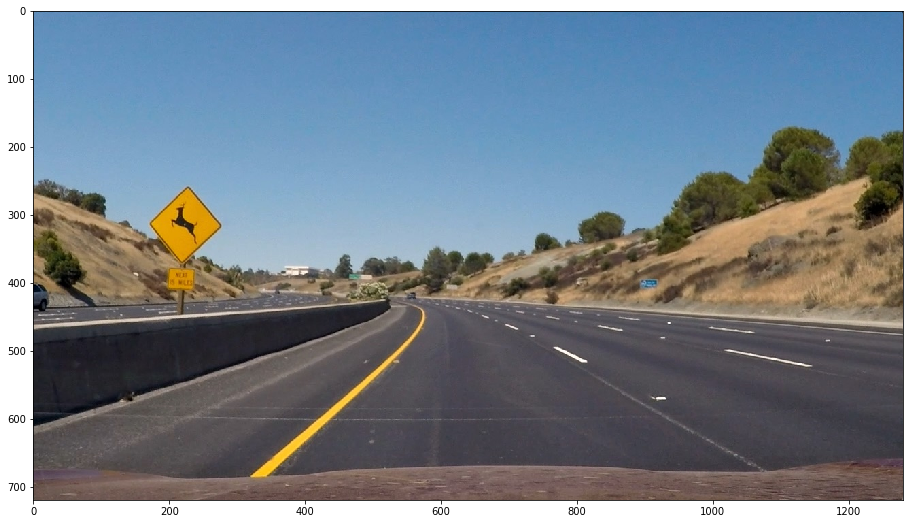

In [3]:
fnames = os.listdir("test_images")
idx = 5
fname = fnames[idx]
print(fname)
img = cv2.imread(os.path.join("test_images", fname))
plot_color_image(img)

In [4]:
# first load mtx and dist
pickle_file = "camera_cal/dist_pickle.p"
dict_pickle = pickle.load(open(pickle_file, "rb"))
mtx, dist = dict_pickle["mtx"], dict_pickle["dist"]

I experimented with various values for the source and destination polygons and have found these settings to provide reasonable results

In [5]:
src = np.float32(
      [[ 585,  460],
       [ 203,  720],
       [1126,  720],
       [ 695,  460]])

dst = np.float32(
      [[350,   0.],
       [350, 720.],
       [950, 720.],
       [950,   0.]])

In [6]:
warped_img, M = streetview2birdview(img, mtx, dist, src, dst, img_size=(img.shape[1], img.shape[0]))

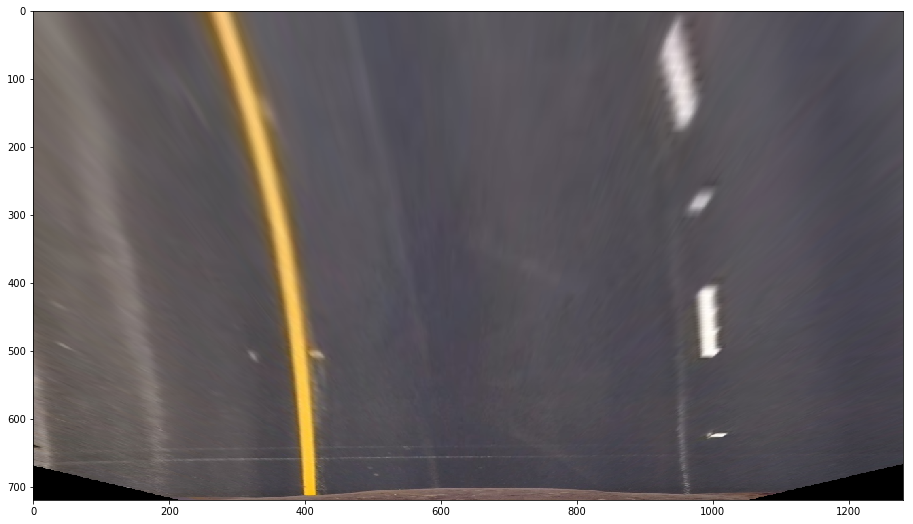

In [7]:
plot_color_image(warped_img) # seems plausible

#### Step 3: Color Thresholding

In [8]:
# Define various color thresholded binary images using different filters
grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
s_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
l_binary = hls_thresh(warped_img, hls_channel="L", thresh=(30, 100))
r_binary = rgb_thresh(warped_img, rgb_channel="R", thresh=(200, 255))
assert grad_binary.shape == mag_binary.shape == dir_binary.shape == s_binary.shape == warped_img.shape[:2] 

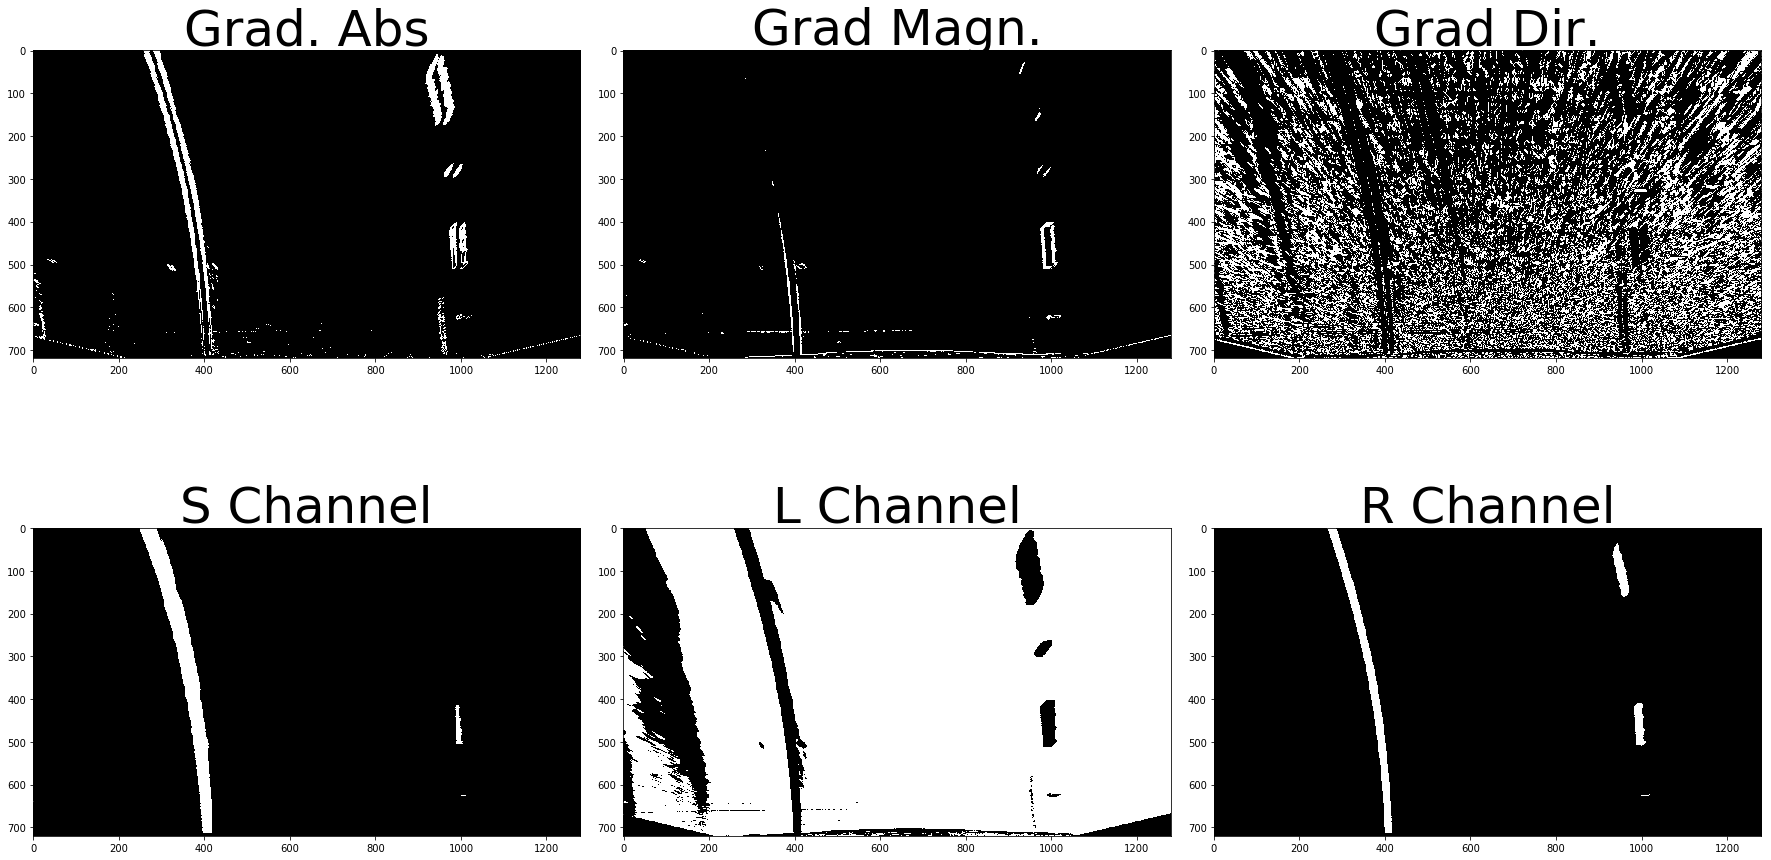

In [9]:
f, axes = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
axes[0][0].imshow(grad_binary, cmap="gray")
axes[0][0].set_title('Grad. Abs', fontsize=50)
axes[0][1].imshow(mag_binary, cmap='gray')
axes[0][1].set_title('Grad Magn.', fontsize=50)
axes[0][2].imshow(dir_binary, cmap='gray')
axes[0][2].set_title('Grad Dir.', fontsize=50)
axes[1][0].imshow(s_binary, cmap='gray')
axes[1][0].set_title('S Channel', fontsize=50)
axes[1][1].imshow(l_binary, cmap='gray')
axes[1][1].set_title('L Channel', fontsize=50)
axes[1][2].imshow(r_binary, cmap='gray')
axes[1][2].set_title('R Channel', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.4, bottom=0.)

In [10]:
# Combine thresholds, e.g. using the S and R channel
combined_binary = np.zeros_like(dir_binary)
# combined_binary[((hls_binary == 1) & (l_binary==0)) | (r_binary==1) | ((grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 0)))] = 1
combined_binary[((s_binary == 1) | (r_binary==1))] = 1

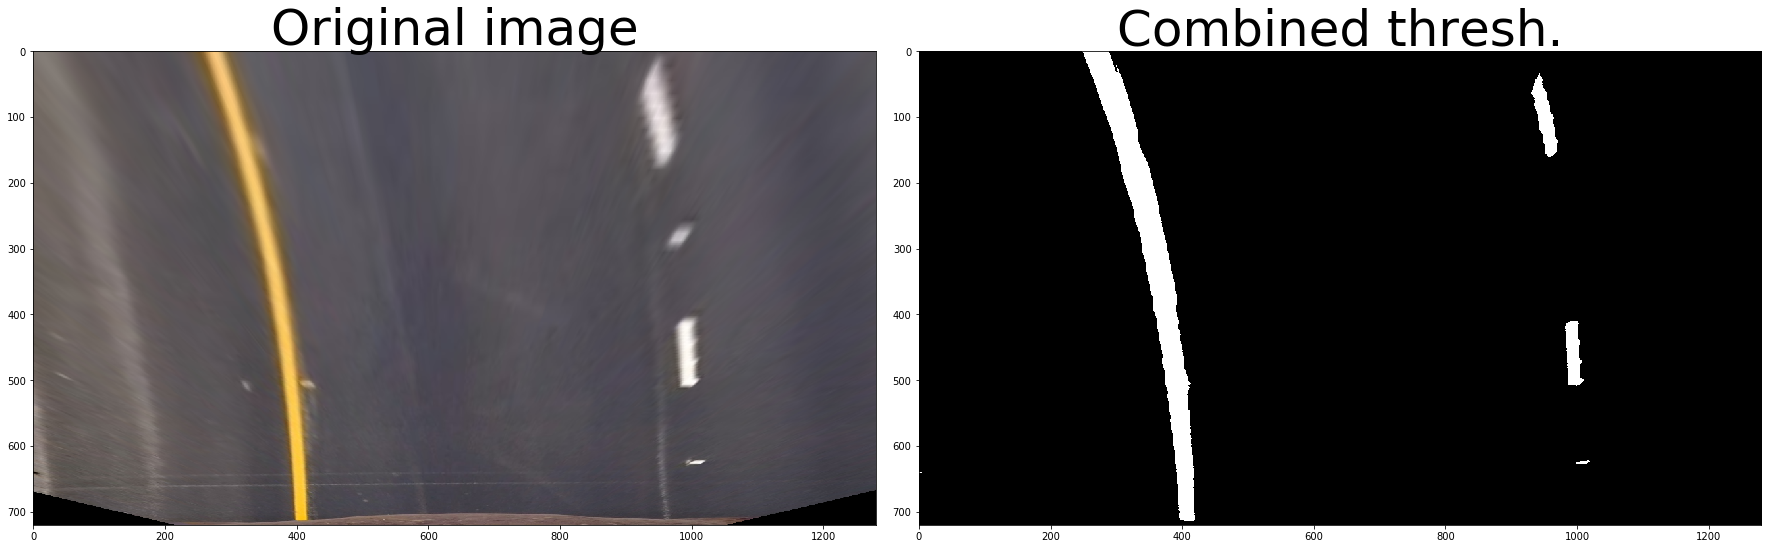

In [11]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined thresh.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Step 4: Find lane lines

From Scratch

In [12]:
left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary, draw_lanes=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


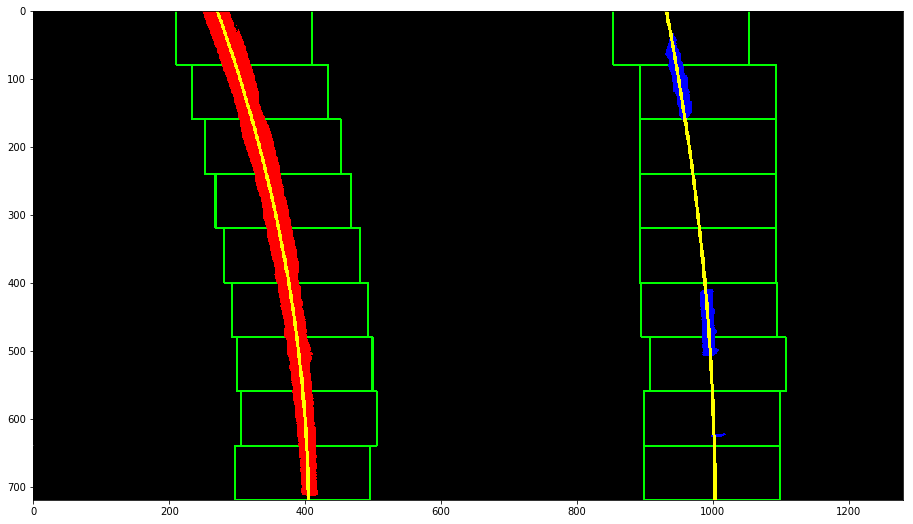

In [13]:
plot_image(out_img)


# red and blue are the detected pixels of left and right lane, respectively
# yellow is the fitted polynomial of second order to these pixels
# green denotes the sliding windows for finding the lane pixels

From Prior Search

In [14]:
# Note that when applied on videos, the previous image needs to be passed as input
left_fitx, right_fitx, _, _, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, left_fit, right_fit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


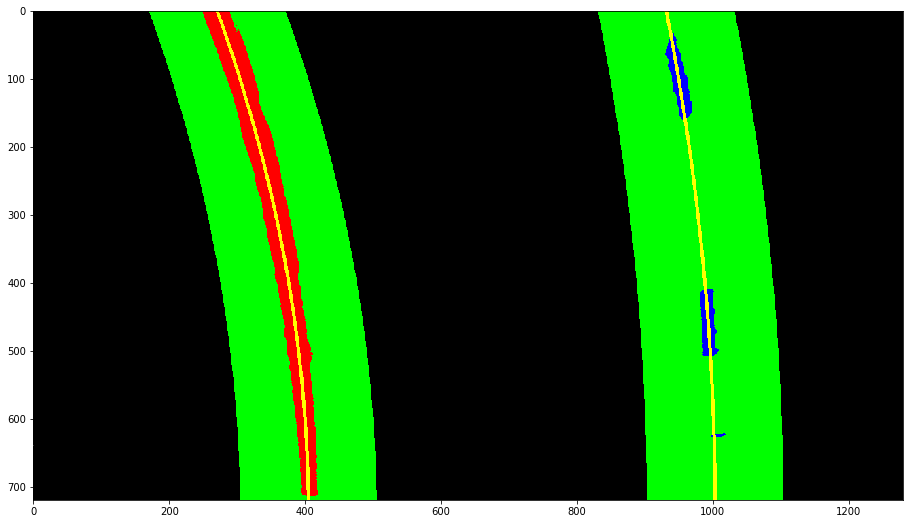

In [15]:
plot_image(out_img)  

# green denotes the margin around which the lanes are searched from the previously detected lane

#### 5. Calculate lane curvature and offset from road center


In [16]:
left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)

In [17]:
print(f"left curve radius: {left_curverad}m, right curve radius: {right_curverad}m")

left curve radius: 684.4224009416342m, right curve radius: 1238.6782621218688m


In [18]:
offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)

In [19]:
print(f"Offset is {offset}m")

Offset is -0.34065486626165387m


#### 6. Warp back detected lanes to original image

In [20]:
img_with_lane = birdview2streetview(out_img, img, combined_binary, dst, src, left_fitx, right_fitx, ploty)

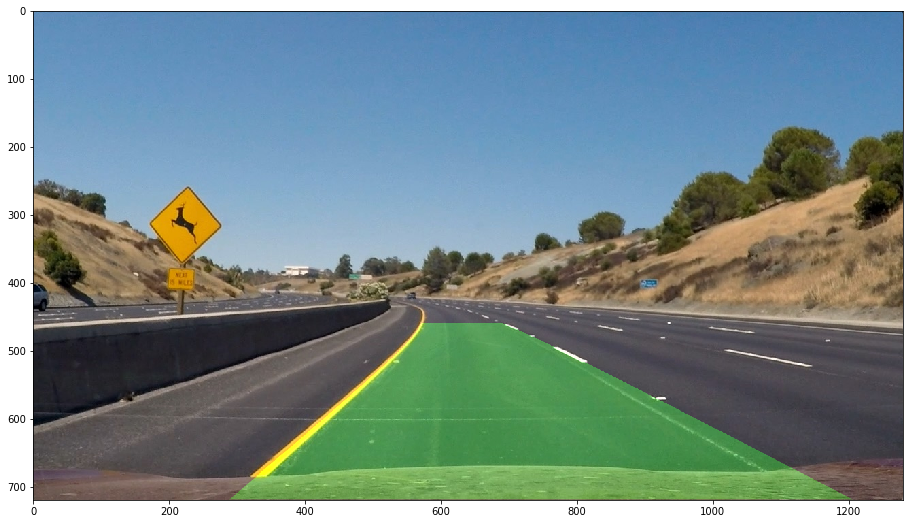

In [21]:
plot_image(img_with_lane)

#### 7. Project curvatures and offset values onto image

In [22]:
img_with_lane = show_crv_and_offset(img_with_lane, left_curverad, right_curverad, offset)

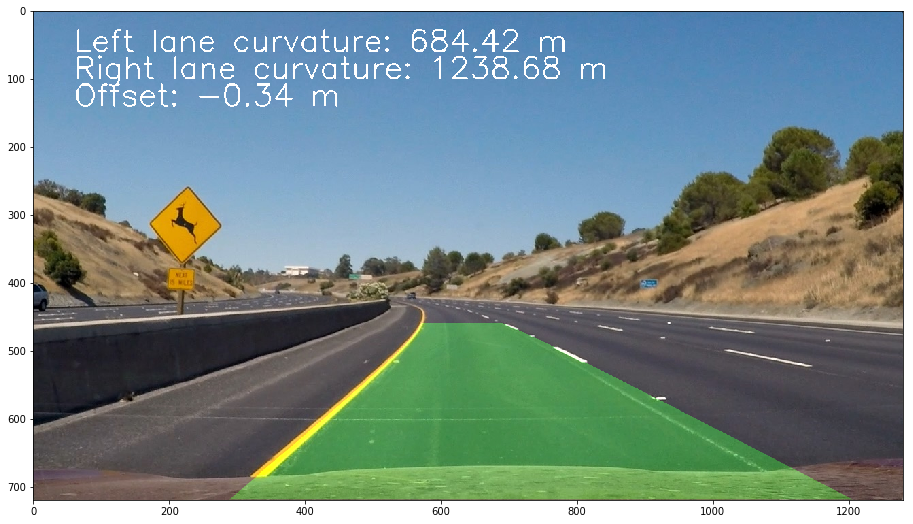

In [23]:
plot_image(img_with_lane)

### Pipeline

Let's go through the entire lane detection pipeline on all the images in `test_images` folder and save the result to `output_images`

In [160]:
# Run the previous cells from above to obtain mtx, dist, src and dst

In [24]:
# Let's define some helper functions/wrappers
def warp_to_orig(out_img, orig_img, combined_binary, dst, src, left_fitx, right_fitx, ploty, left_crv, right_crv, offset):
    img_with_lane = birdview2streetview(out_img, orig_img, combined_binary, dst, src, left_fitx, right_fitx, ploty)
    img_with_lane = show_crv_and_offset(img_with_lane, left_crv, right_crv, offset)
    return img_with_lane

def hls_rgb_thresh(img, hls_channel, rgb_channel, hls_threshold, rgb_threshold):
    # For the sake of demonstration, let's only use the thresholding from HLS and RGB space
    s_binary = hls_thresh(img, hls_channel=hls_channel, thresh=hls_threshold)
    r_binary = rgb_thresh(img, rgb_channel=rgb_channel, thresh=rgb_threshold)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((s_binary == 1) | (r_binary==1))] = 1
    return combined_binary

def calc_lane_crv_and_offset(left_fitx, right_fitx, ploty, midpoint):
    left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
    offset = measure_offset(left_fitx, right_fitx, midpoint)
    return left_curverad, right_curverad, offset

In [25]:
# First we define a wrapper function for the entire pipeline
# Note that the camera does not need to be calibrated again

def lane_detection_pipeline(img, warp_func, color_thresh_func, find_lanes_func, calc_lane_params_func, warp_back_func):
    # Transform to bird-eye perspective
    warped_img, M = warp_func(img)
    # Color Threshold
    combined_binary = color_thresh_func(warped_img)
    # Detect lane lines (for the sake of this exercise, let's do it from scratch)
    left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_func(combined_binary)
    # Calculate curvature and offset
    left_curverad, right_curverad, offset = calc_lane_params_func(left_fitx, right_fitx, ploty)
    # Warp back to original image and project onto original image
    img_with_lane = warp_back_func(out_img=out_img, orig_img=img, combined_binary=combined_binary, left_fitx=left_fitx, 
                          right_fitx=right_fitx, ploty=ploty, left_crv=left_curverad, right_crv=right_curverad, offset=offset)
    # Return all intermediate steps for visualization
    return warped_img, combined_binary, out_img, img_with_lane

In [26]:
warp = partial(streetview2birdview, mtx=mtx, dist=dist, src=src, dst=dst, img_size=(1280, 720))
color_thresh = partial(hls_rgb_thresh, hls_channel="S", rgb_channel="R", hls_threshold=(90, 255), rgb_threshold=(200, 255))
calc_lane_params = partial(calc_lane_crv_and_offset, midpoint=640)
warp_back = partial(warp_to_orig, dst=dst, src=src)

In [54]:
def plot_pipeline(fname, warped_img, combined_binary, out_img, img_with_lane, savefig=True):
    
    img = cv2.imread(os.path.join("test_images", fname))
    
    f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(24, 9))
    f.tight_layout()
    ax0.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax0.set_title(f'{fname}', fontsize=20)
    ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Warped', fontsize=20)
    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('Combined thresh.', fontsize=20)
    ax3.imshow(out_img, cmap='gray')
    ax3.set_title('Lane pixels', fontsize=20)
    ax4.imshow(img_with_lane)
    ax4.set_title('Detected lanes', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    if savefig:
        out_file = os.path.join("output_images", f"{fname[:-4]}_warped.jpg")
        cv2.imwrite(out_file, cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
        
        out_file = os.path.join("output_images", f"{fname[:-4]}_colorthresh.jpg")
        cv2.imwrite(out_file, combined_binary*255)
        
        out_file = os.path.join("output_images", f"{fname[:-4]}_lanesearch.jpg")
        cv2.imwrite(out_file, cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        
        out_file = os.path.join("output_images", f"{fname[:-4]}_withlanes.jpg")
        cv2.imwrite(out_file, cv2.cvtColor(img_with_lane, cv2.COLOR_RGB2BGR))

In [55]:
warped_img, combined_binary, out_img, img_with_lane = lane_detection_pipeline(img, warp_func=warp, 
                                                                              color_thresh_func=color_thresh,
                                                                              find_lanes_func=find_lanes_from_scratch,
                                                                              calc_lane_params_func=calc_lane_params,
                                                                              warp_back_func=warp_back)

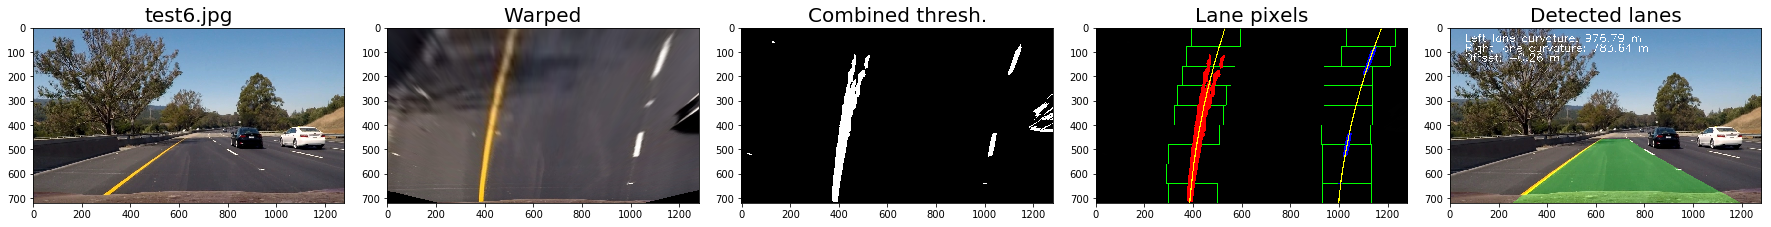

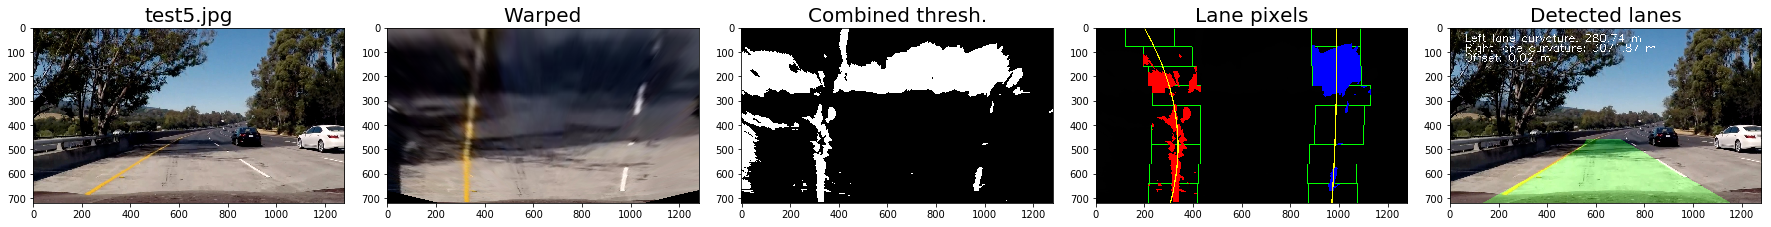

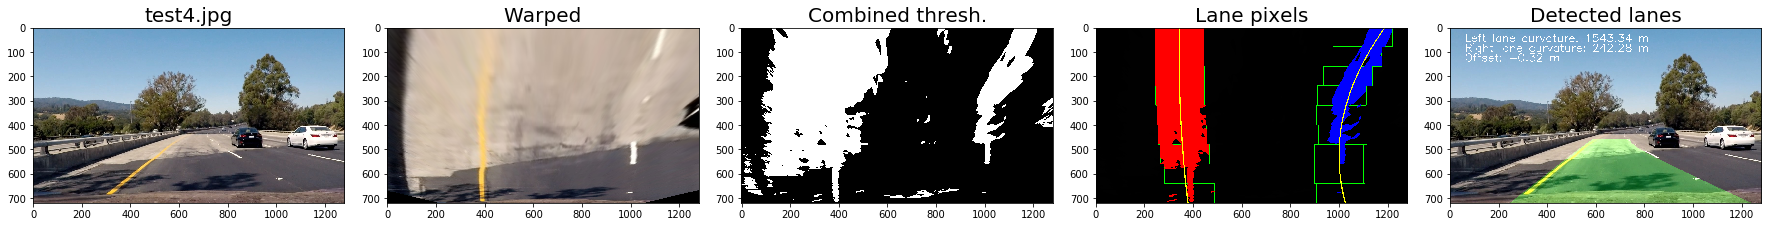

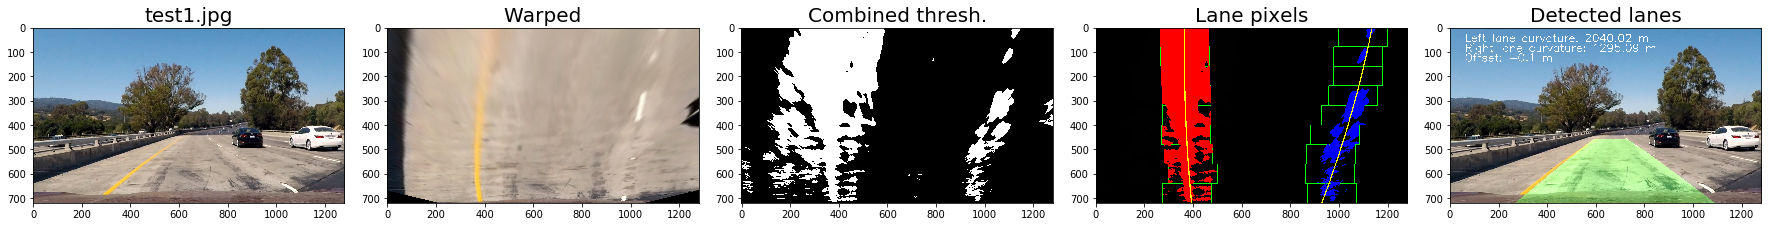

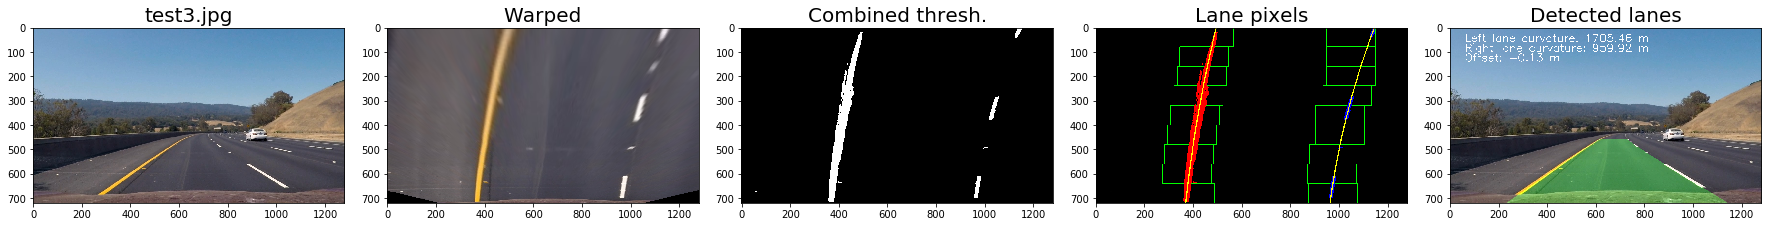

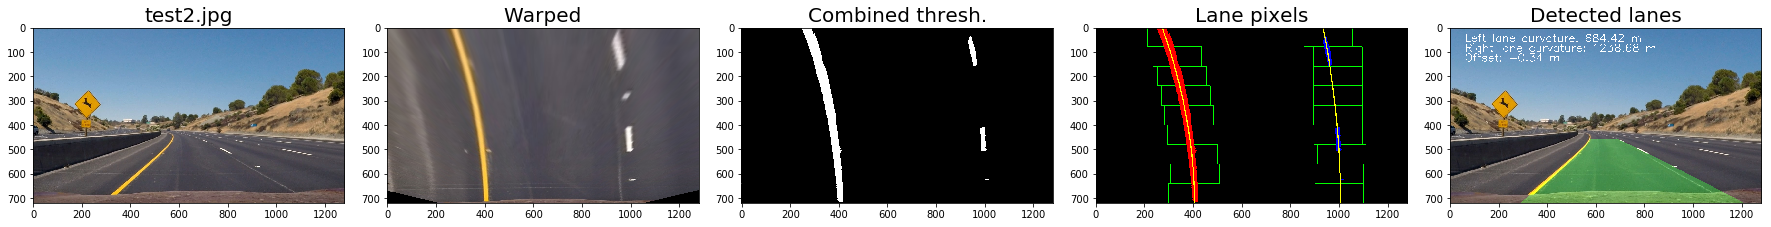

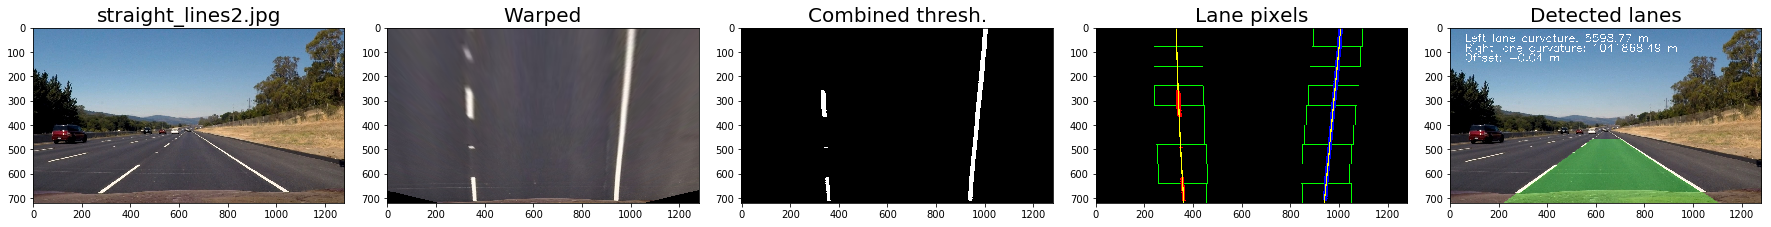

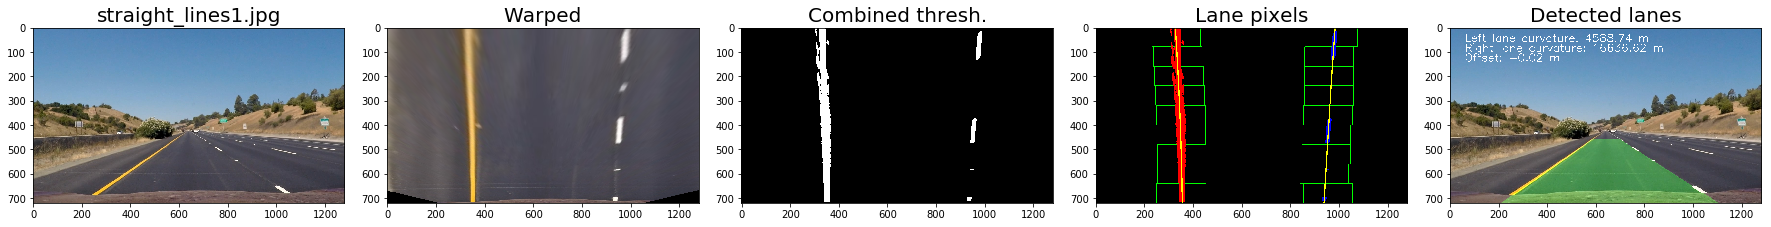

In [56]:
for fname in fnames:
    img = cv2.imread(os.path.join("test_images", fname))
    warped_img, combined_binary, out_img, img_with_lane = lane_detection_pipeline(img, warp_func=warp, 
                                                                              color_thresh_func=color_thresh,
                                                                              find_lanes_func=find_lanes_from_scratch,
                                                                              calc_lane_params_func=calc_lane_params,
                                                                              warp_back_func=warp_back)
    plot_pipeline(fname, warped_img, combined_binary, out_img, img_with_lane)

We can see that the R channel filter in RGB space produces very clear images of both lines under optimal lighting conditions. 
However when there are shadows or reflections the R-filtered image is quite "noisy". Therefore it seems to be that this type of filter is not robust to changing environments. In the following video pipeline, we will use a different type of color thresholding

### Test on video

First let's define a class which stores attributes across frames. I will use the example class proposed in the lecture materials with some slight modifications (e.g. I won't be using all of the attributes)

In [46]:
#import imageio
#imageio.plugins.ffmpeg.download()

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #polynomial coefficients for the most recent fit
        # self.current_fit = [np.array([False])]  
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # incremental counter for frames where a lane line has not been found
        self.not_found_counter = 0  
        # dummy flag which indicates that for the first frame of the video, the lane line has to be detected from scratch
        self.initial_scratch_search = True
        # threshold for the number of continuous frames with no lane lines detected (if this threshold is reached, a search from scratch will be triggered)
        self.continuous_frames_with_no_lanes = 5
        # an incremental counter for the number of frames, resets to 0 if the buffer is reached
        self.frame_counter = 0
        # length of continuous frames which are stored in a buffer; determines length of self.recent_xfitted
        self.frame_buffer = 12

#### Idea

The idea for detecting lanes is to find them from prior frames as much as possible. However that function does not necessarily need to detect a lane, as opposed to finding lanes from scratch function which always has to find a lane.

We introduce an additional function output (also see above and the lane_find.py module) called the detected_flag which indicates if a lane has been found. This flag will be saved as a class attribute for each frame.

For the following video pipeline, I have tested the switch from finding lanes from prior frames to finding lanes from scratch by setting a very small search margin. If the margin is too small (e.g. 10 - 20 pixels) then we can enforce a search from scratch.

Also I have introduced additional class attributes for smoothing lanes. I'm saving the x-values of the fitted polynomials for the last 12 frames. Then I'm taking the median (as opposed to the mean in order to counter the effect of possible outliers) of those polynoms as the lane polynom for the current frame. This makes the detected lanes less noisy and appear more smooth across frames. 

In [37]:
# this function stores a list which contains exactly list_len items; 
# if the list contains less items it appends new items to the end of the list, if it contains five items it choses the item of index "index" to be replaced by the newest item
# this function is used in the video processing pipeline
def append_or_replace(l_list, index, item, list_len=5):
    if len(l_list)<list_len:
        l_list.append(item)
    else:
        l_list[index] = item
    assert len(l_list)<=list_len

In [43]:
def process_video(image):
    # transform image to birds-eye perspective
    warped_img, M = streetview2birdview(image, mtx, dist, src, dst, img_size=(image.shape[1], image.shape[0]))
    
    # calculate color thresholds; here we use sobel filter in x direction, magnitude threshold, direction threshold and S channel threshold
    grad_binary = abs_sobel_thresh(warped_img, orient='x', thresh=(20, 100), sobel_kernel=3)
    mag_binary = mag_thresh(warped_img, thresh=(30, 100), sobel_kernel=3)
    dir_binary = dir_thresh(warped_img, thresh=(0.7, 1.3), sobel_kernel=15)
    s_binary = hls_thresh(warped_img, hls_channel="S", thresh=(90, 255))
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(grad_binary == 1) | (s_binary == 1) | ( ((mag_binary == 1) & (dir_binary == 0)))] = 1
    
    # Search for lane lines: Enforce search from scratch on frame 0
    if leftlane.initial_scratch_search or rightlane.initial_scratch_search:
        left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
        leftlane.detected, rightlane.detected = True, True
        leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
        leftlane.initial_scratch_search, rightlane.initial_scratch_search = False, False
        
    # if no lane detected, increase the counter of frames with no lanes found; if the counter exceeds threshold search again from scratch
    if not leftlane.detected or not rightlane.detected:  
        leftlane.not_found_counter += 1
        rightlane.not_found_counter += 1
        # if no lane lines found, simply return the image with curvature and offset parameters printed (these will be obtained from the last time the radius and offset were calculated)
        if leftlane.not_found_counter < leftlane.continuous_frames_with_no_lanes: 
            result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
            return result
        # search from scratch if threshold for no lanes found is exceeded
        else:
            left_fitx, right_fitx, left_fit, right_fit, ploty, out_img, detected_flag = find_lanes_from_scratch(combined_binary)
            leftlane.detected, rightlane.detected = True, True
            leftlane.current_fit, rightlane.current_fit = left_fit, right_fit
            leftlane.not_found_counter, rightlane.not_found_counter = 0, 0  # reset counter
    else:  # if lanes detected previously, simply search from previous frame around margin
        left_fitx, right_fitx, leftlane.current_fit, rightlane.current_fit, ploty, out_img, detected_flag = find_lanes_from_prior(combined_binary, leftlane.current_fit, rightlane.current_fit, margin=100)
        leftlane.detected = detected_flag  
        rightlane.detected = detected_flag
        leftlane.not_found_counter, rightlane.not_found_counter = 0, 0  # reset counter of frames with no lane lines found
        
    # store fitted pixels of lanes in list using a FIFO (first in, first out) rule; oldest pixel values will be replaced
    append_or_replace(leftlane.recent_xfitted, leftlane.frame_counter%leftlane.frame_buffer, left_fitx, list_len=leftlane.frame_buffer)
    append_or_replace(rightlane.recent_xfitted, rightlane.frame_counter%rightlane.frame_buffer, right_fitx, list_len=rightlane.frame_buffer)
    
    # use median of all pixel values in list as actual fit
    try:  # to avoid a bad start (might happen when margin is set too small)
        left_fitx = np.median(np.array([x for x in leftlane.recent_xfitted if x is not None]), axis=0)  # using median because more robust against outliers
        right_fitx = np.median(np.array([x for x in rightlane.recent_xfitted if x is not None]), axis=0)
    except:
        pass
    
    # calculate road parameters, save in class attributes and display on image with warped back lane lines
    try:
        left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
        offset = measure_offset(left_fitx, right_fitx, midpoint=out_img.shape[1]//2)
        leftlane.radius_of_curvature, rightlane.radius_of_curvature = left_curverad, right_curverad
        leftlane.line_base_pos, rightlane.line_base_pos = offset, offset
        img_with_lane = birdview2streetview(out_img, image, combined_binary, dst, src, left_fitx, right_fitx, ploty)
        result = show_crv_and_offset(img_with_lane, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    except:  # if not possible, simply use image without lane lines
        result = show_crv_and_offset(image, leftlane.radius_of_curvature, rightlane.radius_of_curvature, leftlane.line_base_pos)
    
    # increase counter for frames
    leftlane.frame_counter+=1
    rightlane.frame_counter+=1
    
    # if frame counter reaches buffer threshold, reset
    if leftlane.frame_counter == leftlane.frame_buffer or rightlane.frame_counter == rightlane.frame_buffer:
        leftlane.frame_counter, rightlane.frame_counter = 0, 0
    
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

Let's run the pipeline on the project video

In [46]:
leftlane = Line()
rightlane = Line()
input_video = './project_video.mp4'
output_video = './project_video_result.mp4'

clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(process_video)

%time white_clip.write_videofile(output_video, audio=False, progress_bar=False)

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

CPU times: user 3min 29s, sys: 56.5 s, total: 4min 26s
Wall time: 3min 29s


In [47]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

Let's try it on the challenge video

In [48]:
leftlane = Line()
rightlane = Line()
input_video = './challenge_video.mp4'
output_video = './challenge_video_result.mp4'

clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(process_video)

%time white_clip.write_videofile(output_video, audio=False, progress_bar=False)

[MoviePy] >>>> Building video ./challenge_video_result.mp4
[MoviePy] Writing video ./challenge_video_result.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_result.mp4 

CPU times: user 1min 20s, sys: 22.7 s, total: 1min 43s
Wall time: 1min 22s


In [49]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

Smoothing across previous frames actually helps in this case; the lane lines less noisy and jump around less from frame to frame

Finally, on the most difficult challenge video

In [50]:
leftlane = Line()
rightlane = Line()
input_video = './harder_challenge_video.mp4'
output_video = './harder_challenge_video_result.mp4'

clip1 = VideoFileClip(input_video)

white_clip = clip1.fl_image(process_video)

%time white_clip.write_videofile(output_video, audio=False, progress_bar=False)

[MoviePy] >>>> Building video ./harder_challenge_video_result.mp4
[MoviePy] Writing video ./harder_challenge_video_result.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_result.mp4 

CPU times: user 3min 26s, sys: 56 s, total: 4min 22s
Wall time: 3min 31s


In [51]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))

One can see that the lane detection algorithm does not work well on the last video (possibly due to extreme changes in lighting, lots of shadows, quick curve changes)

### Ideas for improving the pipeline

- separate the search of the left and right lane lines: currently both are done in the same function. 
However it could be the case that only one of the lane lines is found. In that case there is no need to trigger a re-search from scratch for both lane lines, but only for the one which has not been found.

- deal with intersecting lane lines: sometimes when the lines are detected incorrectly (left lane curves to the right, right lane curves to the left), the left lane and right lane will intersect. In this case one could add a sanity check for detecting cases where the minimum x-pixel of the right lane is smaller than the maximum x-pixel of the left lane (meaning intersection). When that happens one could trigger a search from scratch or use a smaller src/dst polygon for the warping

- calculate lane width: an additional check would be to calculate lane width (right lane x-pixel minus left lane x-pixel); if it's too wide (e.g. right lane detected outside the actual lane) one could start a search from scratch


- alternative approach to smoothing lanes across frames: in my current approach I am returning the left_fitx and right_fitx values from the already fit polynomes and average across those values; an alternative approach would be to return the leftx and rightx pixel values, average across those and then fit a polynom on the averaged pixels


- diverging curvatures: if the curvatures of left and right lane lines diverge too much (let's say a factor of 10), one can mirror the polynom of either the left or right lane to the other side


- fit more complex polynomial: under extreme curve situations (tight left curve followed directly by tight right curve), a polynomial of second degree does not properly represent the curvature anymore, in that case a more complex polynom might be more fitting


- better parameter tuning: there are many parameters which can be more carefully tuned (such as the size of the warping polynoms src and dst, the thresholds for the filters etc.). Or one could use a set of multiple parameters for multiple situations or even dynamic parameters.
